In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [5]:
# Cargar los datos
datos = pd.read_excel("mensuales.xlsx")
datos.columns = ['Fecha', 'Precipitacion']
datos.set_index('Fecha', inplace=True)

# Verificar las primeras filas para asegurar que está correcto
print(datos.head())

            Precipitacion
Fecha                    
1982-01-01          766.0
1982-02-01         2718.0
1982-03-01         1331.0
1982-04-01         4939.0
1982-05-01         6078.0


In [6]:
# Extraer la serie de precipitaciones
precipitacion = datos['Precipitacion']

In [7]:
datos.shape

(492, 1)

In [8]:
# Suponiendo que 'datos' es tu DataFrame
# Imprime las primeras filas del DataFrame para verificar la estructura de los datos
print("Estructura de 'datos':")
print(datos.head())

# Asegúrate de que 'Fecha' esté en el formato correcto (sin espacios adicionales, etc.)
datos.columns = datos.columns.str.strip()

# Verifica nuevamente las columnas después de limpiar los nombres
print("Columnas después de limpiar:", datos.columns)

# Intenta establecer 'Fecha' como índice del DataFrame
if 'Fecha' in datos.columns:
    datos.set_index('Fecha', inplace=True)
else:
    print("No se encontró la columna 'Fecha' en 'datos'. Verifica la estructura de tus datos.")

# Verifica el índice después de establecerlo
print("Índice del DataFrame 'datos':")
print(datos.index)

Estructura de 'datos':
            Precipitacion
Fecha                    
1982-01-01          766.0
1982-02-01         2718.0
1982-03-01         1331.0
1982-04-01         4939.0
1982-05-01         6078.0
Columnas después de limpiar: Index(['Precipitacion'], dtype='object')
No se encontró la columna 'Fecha' en 'datos'. Verifica la estructura de tus datos.
Índice del DataFrame 'datos':
DatetimeIndex(['1982-01-01', '1982-02-01', '1982-03-01', '1982-04-01',
               '1982-05-01', '1982-06-01', '1982-07-01', '1982-08-01',
               '1982-09-01', '1982-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='Fecha', length=492, freq=None)


In [9]:
print(datos.head)

<bound method NDFrame.head of             Precipitacion
Fecha                    
1982-01-01          766.0
1982-02-01         2718.0
1982-03-01         1331.0
1982-04-01         4939.0
1982-05-01         6078.0
...                   ...
2022-08-01         5353.0
2022-09-01         4017.0
2022-10-01         3668.0
2022-11-01          461.0
2022-12-01         1002.0

[492 rows x 1 columns]>


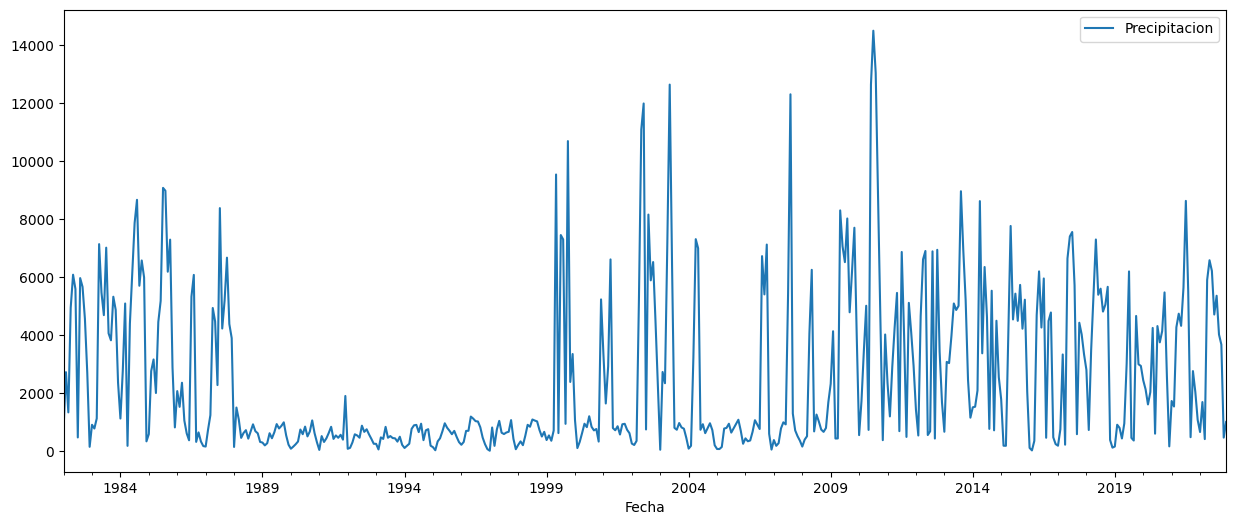

In [10]:
datos.plot(figsize=(15, 6))
plt.show()

Epoch 1/50
24/24 [==============================] - 2s 28ms/step - loss: 0.0424 - val_loss: 0.0278
Epoch 2/50
24/24 [==============================] - 0s 10ms/step - loss: 0.0316 - val_loss: 0.0275
Epoch 3/50
24/24 [==============================] - 0s 7ms/step - loss: 0.0303 - val_loss: 0.0264
Epoch 4/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0297 - val_loss: 0.0264
Epoch 5/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0292 - val_loss: 0.0261
Epoch 6/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0287 - val_loss: 0.0271
Epoch 7/50
24/24 [==============================] - 0s 7ms/step - loss: 0.0286 - val_loss: 0.0258
Epoch 8/50
24/24 [==============================] - 0s 7ms/step - loss: 0.0285 - val_loss: 0.0257
Epoch 9/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0279 - val_loss: 0.0256
Epoch 10/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0277 - val_loss: 0.0253
Epoch 11/50
24/24

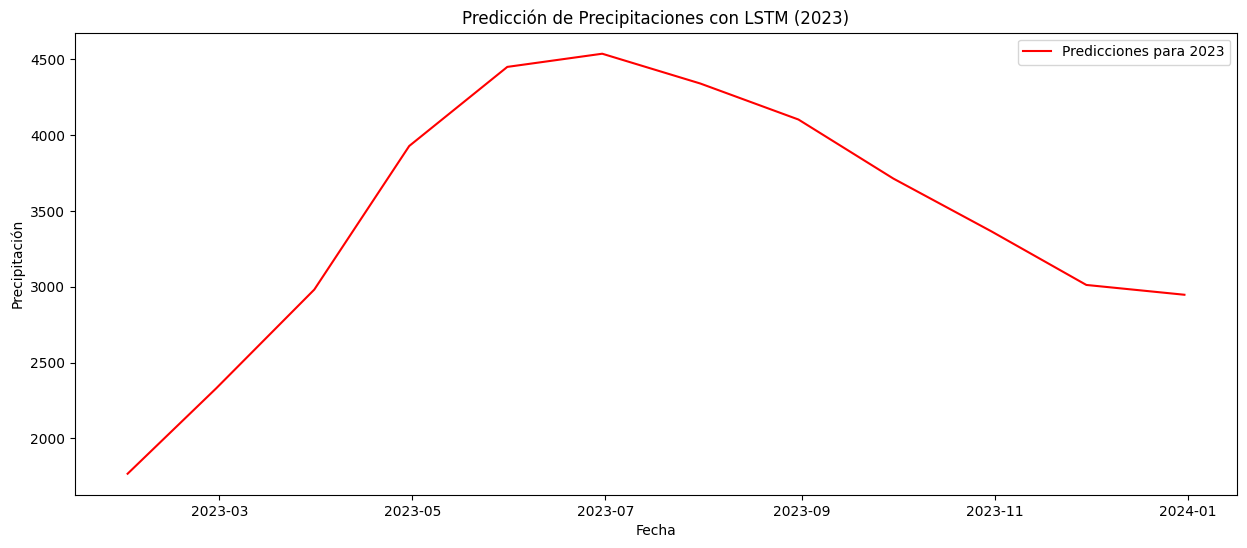

        Fecha  Predicciones
0  2023-01-31   1766.848267
1  2023-02-28   2330.044189
2  2023-03-31   2981.250977
3  2023-04-30   3928.041260
4  2023-05-31   4449.660645
5  2023-06-30   4536.531738
6  2023-07-31   4340.026855
7  2023-08-31   4102.724121
8  2023-09-30   3713.332275
9  2023-10-31   3364.986816
10 2023-11-30   3011.707764
11 2023-12-31   2947.046631


In [16]:
# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
precipitacion_scaled = scaler.fit_transform(datos[['Precipitacion']])

# Crear secuencias de entrenamiento y prueba
seq_length = 12

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append((seq, label))
    return sequences

sequences = create_sequences(precipitacion_scaled, seq_length)
X, y = zip(*sequences)
X = np.array(X)
y = np.array(y)

# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Construir el modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(seq_length, 1)))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Generar predicciones para los próximos 12 meses (año 2023)
future_steps = 12
input_seq = precipitacion_scaled[-seq_length:]  # Últimos 12 meses del conjunto de datos
predicciones_2023 = []

for _ in range(future_steps):
    input_seq = input_seq.reshape((1, seq_length, 1))
    prediccion = model_lstm.predict(input_seq)
    predicciones_2023.append(prediccion[0, 0])
    input_seq = np.append(input_seq[:, 1:, :], np.array(prediccion).reshape(1, 1, 1), axis=1)

# Desescalar las predicciones
predicciones_2023 = scaler.inverse_transform(np.array(predicciones_2023).reshape(-1, 1))

# Crear un rango de fechas para las predicciones de 2023
ult_fecha = datos.index[-1]
fechas_prediccion = pd.date_range(start=ult_fecha + pd.DateOffset(months=1), periods=future_steps, freq='M')

# Crear un DataFrame con las predicciones
predicciones_df = pd.DataFrame({
    'Fecha_prediccion': fechas_prediccion,
    'Valor_predicho': predicciones_2023.flatten()
})

# Filtrar los datos reales para el año 2023
datos_2023 = datos[datos.index.year == 2023]

# Graficar los resultados solo para el año 2023
plt.figure(figsize=(15, 6))
if not datos_2023.empty:
    plt.plot(datos_2023.index, datos_2023['Precipitacion'], label='Datos reales')
plt.plot(predicciones_df['Fecha_prediccion'], predicciones_df['Valor_predicho'], label='Predicciones para 2023', color='red')
plt.title('Predicción de Precipitaciones con LSTM (2023)')
plt.xlabel('Fecha')
plt.ylabel('Precipitación')
plt.legend()
plt.show()

# Mostrar los resultados en una tabla
resultados_df = pd.DataFrame({
    'Fecha': predicciones_df['Fecha_prediccion'],
    'Predicciones': predicciones_df['Valor_predicho']
})
print(resultados_df)
